In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/ntasfi/PyGame-Learning-Environment "/content/drive/MyDrive/Colab Notebooks/dl/lecture14/rep"

In [ ]:
import os

# 切换工作目录到在 Drive 中克隆的仓库路径
repo_path = "/content/drive/MyDrive/Colab Notebooks/dl/lecture14/rep"
if os.path.exists(repo_path):
    os.chdir(repo_path)
    print(f"Changed directory to: {os.getcwd()}")
else:
    print(f"Path not found: {repo_path}. Please check if the drive is mounted and the path is correct.")

In [ ]:
# 在当前目录下安装 PLE 环境
!pip install -e .

In [ ]:
# Install pygame
!pip install pygame

Code

In [ ]:
from ple.games.flappybird import FlappyBird
from ple import PLE
import matplotlib.pyplot as plt
import os
import numpy as np

%matplotlib inline
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line disable pop-out window
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

In [ ]:
# return a dictionary whose key is action description and value is action index
print(game.actions)
# return a list of action index (include None)
print(env.getActionSet())

In [ ]:
# a dictionary describe state
'''
    player y position.
    players velocity.
    next pipe distance to player
    next pipe top y position
    next pipe bottom y position
    next next pipe distance to player
    next next pipe top y position
    next next pipe bottom y position
'''
game.getGameState()

Q-learning

In [ ]:
import math
import copy
from collections import defaultdict
MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5


class Agent:

    def __init__(self,
                 bucket_range_per_feature,
                 num_action,
                 t=0,
                 discount_factor=0.99):
        self.update_parameters(t)  # init explore rate and learning rate
        self.q_table = defaultdict(lambda: np.zeros(num_action))
        self.discount_factor = discount_factor
        self.num_action = num_action

        # how to discretize each feature in a state
        # the higher each value, less time to train but with worser performance
        # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        # epsilon-greedy
        state_idx = self.get_state_idx(state)
        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(num_action)  # Select a random action
        else:
            action = np.argmax(
                self.q_table[state_idx])  # Select the action with the highest q
        return action

    def update_policy(self, state, action, reward, state_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Update Q_value using Q-learning update rule
        best_q = np.max(self.q_table[state_prime_idx])
        self.q_table[state_idx][action] += self.learning_rate * (
            reward + self.discount_factor * best_q - self.q_table[state_idx][action])

    def get_state_idx(self, state):
        # instead of using absolute position of pipe, use relative position
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # sort to make list converted from dict ordered in alphabet order
        state_key = [k for k, v in sorted(state.items())]

        # do bucketing to decrease state space to speed up training
        state_idx = []
        for key in state_key:
            state_idx.append(
                int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(MIN_EXPLORING_RATE,
                                  min(0.5, 0.99**((episode) / 30)))
        self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99
                                                        ** ((episode) / 30)))

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0

In [ ]:
num_action = len(env.getActionSet())
bucket_range_per_feature = {
  'next_next_pipe_bottom_y': 40,
  'next_next_pipe_dist_to_player': 512,
  'next_next_pipe_top_y': 40,
  'next_pipe_bottom_y': 20,
  'next_pipe_dist_to_player': 20,
  'next_pipe_top_y': 20,
  'player_vel': 4,
  'player_y': 16
}
# init agent
agent = Agent(bucket_range_per_feature, num_action)

In [ ]:
import moviepy.editor as mpy


def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip

In [ ]:
from IPython.display import Image, display
import pickle
import os

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 40000

checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/dl/lecture14/checkpoint"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
best_cum_reward = -float('inf')


for episode in range(0, NUM_EPISODE):

    env.reset_game()
    frames = [env.getScreenRGB()]

    if episode % print_every_episode == 0:
        agent.shutdown_explore()

    state = game.getGameState()
    cum_reward = 0
    t = 0

    while not env.game_over():
        action = agent.select_action(state)
        reward = env.act(env.getActionSet()[action])
        frames.append(env.getScreenRGB())
        cum_reward += reward
        state_prime = game.getGameState()
        agent.update_policy(state, action, reward, state_prime)
        state = state_prime
        t += 1


    if cum_reward > best_cum_reward:
        best_cum_reward = cum_reward
        checkpoint_path = os.path.join(
            checkpoint_dir,
            f"qlearning_best_{best_cum_reward:.2f}_ep_{episode}.pkl"
        )
        with open(checkpoint_path, "wb") as f:
        # 只存内容，不存那个带 lambda 的 default factory
          pickle.dump(dict(agent.q_table), f)


    agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode {} finished after {} time steps, cumulated reward: {}, exploring rate: {}, learning rate: {}".format(
            episode,
            t,
            cum_reward,
            agent.exploring_rate,
            agent.learning_rate
        ))
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(agent.exploring_rate)
        learning_rates.append(agent.learning_rate)
        lifetime_per_epoch.append(t)

    if episode % show_gif_every_episode == 0:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))


In [ ]:
from IPython.display import Image, display
import pickle
import os

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 40000

checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/dl/lecture14/checkpoint"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
best_cum_reward = -float('inf')


for episode in range(0, NUM_EPISODE):

    env.reset_game()
    frames = [env.getScreenRGB()]

    if episode % print_every_episode == 0:
        agent.shutdown_explore()

    state = game.getGameState()
    cum_reward = 0
    t = 0

    while not env.game_over():
        action = agent.select_action(state)
        reward = env.act(env.getActionSet()[action])
        frames.append(env.getScreenRGB())
        cum_reward += reward
        state_prime = game.getGameState()
        agent.update_policy(state, action, reward, state_prime)
        state = state_prime
        t += 1


    if cum_reward > best_cum_reward:
        best_cum_reward = cum_reward
        checkpoint_path = os.path.join(
            checkpoint_dir,
            f"qlearning_best_{best_cum_reward:.2f}_ep_{episode}.pkl"
        )
        with open(checkpoint_path, "wb") as f:
        # 只存内容，不存那个带 lambda 的 default factory
          pickle.dump(dict(agent.q_table), f)


    agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode {} finished after {} time steps, cumulated reward: {}, exploring rate: {}, learning rate: {}".format(
            episode,
            t,
            cum_reward,
            agent.exploring_rate,
            agent.learning_rate
        ))
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(agent.exploring_rate)
        learning_rates.append(agent.learning_rate)
        lifetime_per_epoch.append(t)

    if episode % show_gif_every_episode == 0:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))


In [ ]:
def demo():
    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # shutdown exploration to see performance of greedy action
    agent.shutdown_explore()

    # the initial state
    state = game.getGameState()

    while not env.game_over():
        # select an action
        action = agent.select_action(state)

        # execute the action and get reward
        reward = env.act(env.getActionSet()[action])

        frames.append(env.getScreenRGB())

        # observe the result
        state_prime = game.getGameState()  # get next state

        # Setting up for the next iteration
        state = state_prime

    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
    display(clip.ipython_display(fps=60, autoplay=1, loop=1))


demo()

In [ ]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
plt.show()

In [ ]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()

SARSA

In [ ]:
import math
import copy
import numpy as np
MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5

class SarsaAgent:
    def __init__(self, bucket_range_per_feature, num_action, t=0, discount_factor=0.99):
        self.update_parameters(t)
        self.q_table = {} # Use dict for pickle compatibility
        self.discount_factor = discount_factor
        self.num_action = num_action
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        state_idx = self.get_state_idx(state)
        if state_idx not in self.q_table:
            self.q_table[state_idx] = np.zeros(self.num_action)

        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(self.num_action)
        else:
            action = np.argmax(self.q_table[state_idx])
        return action

    def update_policy(self, state, action, reward, state_prime, action_prime):
        s_idx  = self.get_state_idx(state)
        sp_idx = self.get_state_idx(state_prime)

        if s_idx not in self.q_table: self.q_table[s_idx] = np.zeros(self.num_action)
        if sp_idx not in self.q_table: self.q_table[sp_idx] = np.zeros(self.num_action)

        td_target = reward + self.discount_factor * self.q_table[sp_idx][action_prime]
        td_error  = td_target - self.q_table[s_idx][action]
        self.q_table[s_idx][action] += self.learning_rate * td_error

    def get_state_idx(self, state):
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']
        state_key = [k for k, v in sorted(state.items())]
        state_idx = []
        for key in state_key:
            state_idx.append(int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(MIN_EXPLORING_RATE, min(0.5, 0.99**((episode) / 30)))
        self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99 ** ((episode) / 30)))

    def shutdown_explore(self):
        self.exploring_rate = 0

In [ ]:
num_action = len(env.getActionSet())
bucket_range_per_feature = {
  'next_next_pipe_bottom_y': 40,
  'next_next_pipe_dist_to_player': 512,
  'next_next_pipe_top_y': 40,
  'next_pipe_bottom_y': 20,
  'next_pipe_dist_to_player': 20,
  'next_pipe_top_y': 20,
  'player_vel': 4,
  'player_y': 16
}
# init agent
agent = SarsaAgent(bucket_range_per_feature, num_action)

In [ ]:
import moviepy.editor as mpy


def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip

In [ ]:
from IPython.display import Image, display
import pickle
import os
import re

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 40000

# Define checkpoint directory
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/dl/lecture14/checkpoint"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# --- CONFIGURATION FOR RESUMING ---
resume_checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/dl/lecture14/checkpoint/sarsa_best_reward_10.00_episode_11632.pkl"

# Defaults if not resuming or file not found
best_cum_reward = -float('inf')
start_episode = 0

# Try to load the checkpoint
if os.path.exists(resume_checkpoint_path):
    print(f"Loading checkpoint from {resume_checkpoint_path}...")
    try:
        with open(resume_checkpoint_path, 'rb') as f:
            agent.q_table = pickle.load(f)

        # Parse filename to extract state info: sarsa_best_reward_10.00_episode_11632.pkl
        filename = os.path.basename(resume_checkpoint_path)

        # Extract reward
        reward_match = re.search(r"reward_(-?\d+\.\d+)", filename)
        if reward_match:
            best_cum_reward = float(reward_match.group(1))

        # Extract episode
        episode_match = re.search(r"episode_(\d+)", filename)
        if episode_match:
            start_episode = int(episode_match.group(1)) + 1  # Start from the next episode

        print(f"Successfully resumed. Start Episode: {start_episode}, Current Best Reward: {best_cum_reward}")

    except Exception as e:
        print(f"Error loading checkpoint or parsing filename: {e}. Starting from scratch.")
        start_episode = 0
        best_cum_reward = -float('inf')
else:
    print(f"Checkpoint file not found at {resume_checkpoint_path}. Starting training from scratch.")


# Start training loop from start_episode
for episode in range(start_episode, start_episode + NUM_EPISODE):

    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        agent.shutdown_explore()

    # the initial state
    state = game.getGameState()
    # 先在初始状态选一个动作 a
    action = agent.select_action(state)

    # cumulate reward for this episode
    cum_reward = 0
    t = 0

    # SARSA 主循环
    while not env.game_over():

        # 用当前动作 action 与环境交互
        # reward = +1 when pass a pipe, -5 when die
        reward = env.act(env.getActionSet()[action])

        frames.append(env.getScreenRGB())

        # 累加 reward
        cum_reward += reward

        # 得到下一状态 s'
        state_prime = game.getGameState()

        # 在 s' 上按当前策略再选一个动作 a'
        action_prime = agent.select_action(state_prime)

        # 用 SARSA 规则更新 Q(s,a)
        agent.update_policy(state, action, reward, state_prime, action_prime)

        # 为下一轮迭代准备：s ← s', a ← a'
        state, action = state_prime, action_prime
        t += 1

    # Check if current episode's reward is the best so far
    if cum_reward > best_cum_reward:
        best_cum_reward = cum_reward

        # Save the Q-table
        checkpoint_path = os.path.join(checkpoint_dir, f"sarsa_best_reward_{best_cum_reward:.2f}_episode_{episode}.pkl")
        with open(checkpoint_path, 'wb') as f:
            pickle.dump(agent.q_table, f)
        print(f"\nNew best reward {best_cum_reward:.2f} at episode {episode}. Q-table saved to {checkpoint_path}")

        # NEW FEATURE: Display animation for new best record
        print("Displaying animation for new high score...\n")
        try:
            clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
            display(clip.ipython_display(fps=60, autoplay=1, loop=1))
        except Exception as e:
            print(f"Could not generate animation: {e}")

    # 更新 epsilon 和 learning rate
    agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode {} finished after {} time steps, cum_reward: {}, exploring_rate: {}, learning_rate: {}".format(
            episode,
            t,
            cum_reward,
            agent.exploring_rate,
            agent.learning_rate
        ))
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(agent.exploring_rate)
        learning_rates.append(agent.learning_rate)
        lifetime_per_epoch.append(t)

    # for every 5000 episode, record an animation
    if episode % show_gif_every_episode == 0 and episode != start_episode:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def demo():
    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # shutdown exploration to see performance of greedy action
    agent.shutdown_explore()

    # the initial state
    state = game.getGameState()

    while not env.game_over():
        # select an action
        action = agent.select_action(state)

        # execute the action and get reward
        reward = env.act(env.getActionSet()[action])

        frames.append(env.getScreenRGB())

        # observe the result
        state_prime = game.getGameState()  # get next state

        # Setting up for the next iteration
        state = state_prime

    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
    display(clip.ipython_display(fps=60, autoplay=1, loop=1))


demo()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


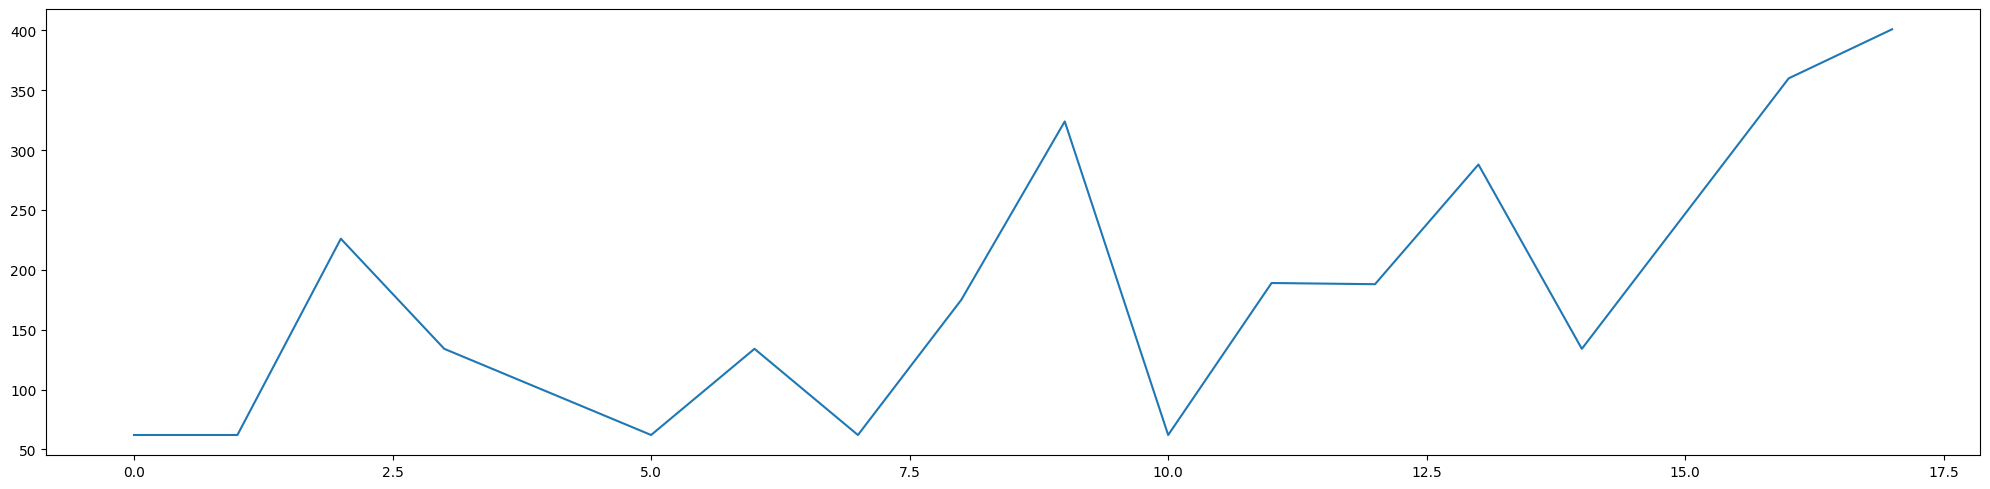

In [ ]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
plt.show()

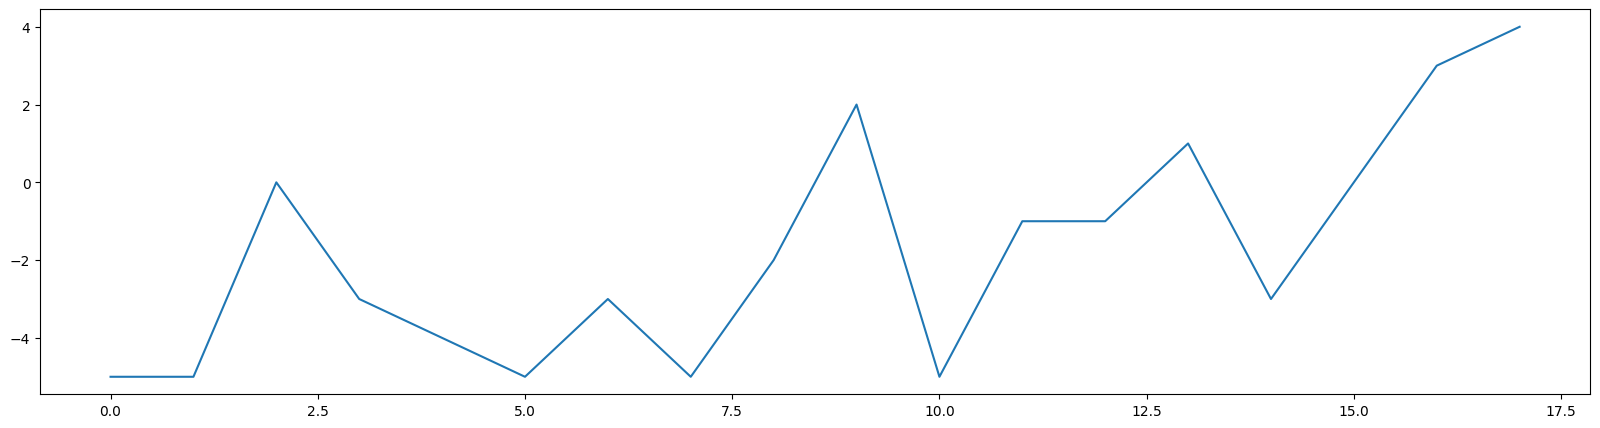

In [ ]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()

總結
根據lifetime per episode 與 reward per episode 的曲線來看：
Q-learning學習進度較慢，直到38個 epoch 左右才出現明顯的上升趨勢，而且曲線抖動較大，此外每個epoch的訓練時間也比較久；
SARSA的學習進度則快一點，在2.5左右就已經出現了上升趨勢，而且抖動不劇烈，同時也意味著他的提升速率沒有Q-learning那麼高，此外每個epoch訓練時間也較短。
